In [2]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import regex
import emoji
plt.style.use('fivethirtyeight')
%matplotlib inline

## Extracting Data 

In [3]:
# Connecting to db
conn = sqlite3.connect('/Users/isacmlee/Desktop/chat.db')
cur = conn.cursor()

# query the database to get all the table names
cur.execute(" select name from sqlite_master where type = 'table' ")

for name in cur.fetchall():
    print(name)

('_SqliteDatabaseProperties',)
('deleted_messages',)
('sqlite_sequence',)
('chat_handle_join',)
('chat_message_join',)
('message_attachment_join',)
('handle',)
('message',)
('chat',)
('attachment',)
('sync_deleted_messages',)
('message_processing_task',)
('sync_deleted_chats',)
('sync_deleted_attachments',)
('kvtable',)
('sqlite_stat1',)


In [4]:
## High Sierra and above
messages = pd.read_sql_query('''select *, datetime(date/1000000000 + strftime("%s", "2001-01-01") ,"unixepoch","localtime")  as date_utc from message''', conn) 

handles = pd.read_sql_query("select * from handle", conn)
chat_message_joins = pd.read_sql_query("select * from chat_message_join", conn)

In [5]:
# these fields are only for ease of datetime analysis (e.g., number of messages per month or year)
messages['message_date'] = messages['date']
messages['timestamp'] = messages['date_utc'].apply(lambda x: pd.Timestamp(x))
messages['date'] = messages['timestamp'].apply(lambda x: x.date())
messages['month'] = messages['timestamp'].apply(lambda x: int(x.month))
messages['year'] = messages['timestamp'].apply(lambda x: int(x.year))


# rename the ROWID into message_id, because that's what it is
messages.rename(columns={'ROWID' : 'message_id'}, inplace = True)

# rename appropriately the handle and apple_id/phone_number as well
handles.rename(columns={'id' : 'phone_number', 'ROWID': 'handle_id'}, inplace = True)

In [6]:
# merge the messages with the handles
merge_level_1 = pd.merge(messages[['text', 'handle_id', 'date','message_date' ,'timestamp', 'month','year','is_sent', 'message_id']],  handles[['handle_id', 'phone_number']], on ='handle_id', how='left')

# and then that table with the chats
df_messages = pd.merge(merge_level_1, chat_message_joins[['chat_id', 'message_id']], on = 'message_id', how='left')

print(len(df_messages))
#print(df_messages.head())

395108


In [7]:
# Replace phone numbers with names
names = ["Carla","Tesa","Tony","Eliot","Isac"]
# Hidden due to privacy
numbers = ["+-----------","+---------","+18182337540","+18186209269",np.nan]

In [8]:
for i in range(len(names)):
    df_messages = df_messages.replace(numbers[i],names[i])

In [9]:
df_messages.phone_number.value_counts()

+18183261197    58389
+18189383037    51802
Isac            51085
Tony            25252
+16262157323    22848
                ...  
ovae                1
+13233206392        1
+13107538318        1
+17606141979        1
+12132385077        1
Name: phone_number, Length: 464, dtype: int64

In [10]:
df_messages = df_messages[df_messages.phone_number != "+18184255611"]

In [11]:
# Groupchat that I want to analyze
name = df_messages[df_messages.chat_id==555].copy()

## Exploratory Data Analysis

#### Most Active 

Text(0.5, 1.0, 'Most Active')

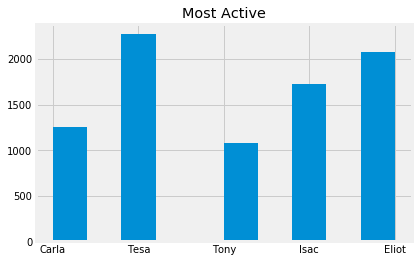

In [16]:
name.phone_number.hist()
plt.title("Most Active")

In [20]:
name['emojis'] = name.text.apply(split_count) # extracting emojis

In [19]:
# Helper function to extract emoji
def split_count(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
    if len(emoji_list) == 0:
        return np.nan
    else:
        return emoji_list

In [21]:
name = name[name['emojis'].notna()]

#### Emoji Usage

In [22]:
# Dataframe for Emoji, Name
emojis_uses = pd.DataFrame(columns=['emojis'])

In [23]:
# Function to get most used emojis for each person
def fav_emojis(df, name):
    df = df[df['phone_number'] == name]
    emoji_list = df['emojis'].tolist()
    flattened = [a for b in df.emojis.tolist() for a in b]
    names = [name] * len(flattened)
    return flattened, names

In [24]:
emoji_column = []
name_column = []
for i in names:
    emoji_temp, name_temp = fav_emojis(name,i)
    emoji_column.append(emoji_temp)
    name_column.append(name_temp)
name_column = [a for b in name_column for a in b]
emoji_column = [a for b in emoji_column for a in b]

In [25]:
emojis_uses['emojis'] = emoji_column
emojis_uses['name'] = name_column

In [74]:
chart = emojis_uses.groupby(['name', 'emojis']).size().unstack(fill_value=0)
chart.sort_values(list(chart.columns),ascending=False)


emojis,‼️,☀️,☣️,♀️,♥️,♻️,⚠️,✈️,✨,❌,...,🤷🏻‍♂️,🥰,🥱,🥳,🥴,🥵,🥺,🦚,🦠,🧬
name,,,,,,,,,,,,,,,,,,,,,
Carla,6,1,1,0,0,0,1,1,0,1,...,0,3,1,2,5,1,33,0,11,1
Tesa,1,0,0,0,2,1,0,0,1,0,...,0,5,2,0,13,1,30,1,0,0
Isac,0,0,0,1,1,0,0,0,0,0,...,1,2,1,1,1,0,10,0,0,0
Tony,0,0,0,0,1,0,0,0,0,0,...,0,1,0,2,4,0,3,0,0,0
Eliot,0,0,0,0,0,0,0,0,0,0,...,0,0,2,2,4,5,20,0,0,0


#### Time Analysis

In [59]:
time_df = df_messages[df_messages.chat_id==555].copy()

In [60]:
time_df.dtypes

text                    object
handle_id                int64
date                    object
message_date             int64
timestamp       datetime64[ns]
month                    int64
year                     int64
is_sent                  int64
message_id               int64
phone_number            object
chat_id                 object
dtype: object

In [61]:
time_df['hour'] = time_df.timestamp.dt.hour
time_df['minutes'] = time_df.timestamp.dt.minute

In [62]:
time_df['time'] = time_df.timestamp.dt.time

In [63]:
time_df = time_df[['text','phone_number','hour','minutes','timestamp','time']]
# time_df.to_csv("time.csv")

In [65]:
time_df.to_csv("time.csv")

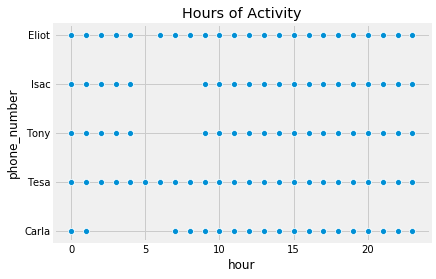

In [57]:
ax = sns.scatterplot(x="hour", y="phone_number", data=time_df)
ax.set_title("Hours of Activity")
plt.show()

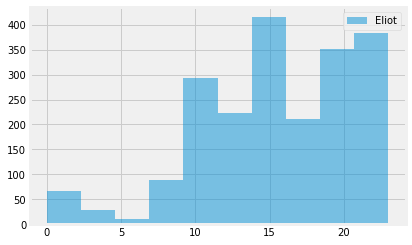

In [58]:
time_df[time_df.phone_number == "Eliot"].hour.hist(bins=10,alpha=.5,label='Eliot')
# time_df[time_df.phone_number == "Carla"].time.hist(bins=10,alpha=.5,label='Carla')
# time_df[time_df.phone_number == "Tony"].hour.hist(bins=10,alpha=.2,label='Tony')
# time_df[time_df.phone_number == "Tesa"].hour.hist(bins=10,alpha=.2,label='Tesa')
# time_df[time_df.phone_number == "Isac"].hour.hist(bins=10,alpha=.2,label='Isac')
plt.legend(loc='upper right')